In [38]:
# Requires 0.24
import os
import sys
sys.path.insert(1,os.path.abspath('../0. Not_git/Sources/scikit-learn/0.24.0'))
import sklearn
print(sklearn.__version__)
#this will be 0.24.2 

0.24.0


### Import libraries

In [39]:
# Modules
import numpy as np
import math
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import pandas as pd

# Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Autoregressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg

# Hyperparameter Grid search
from skforecast.model_selection import grid_search_forecaster

# Backtesting
from skforecast.model_selection import backtesting_forecaster

# Models
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor 
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor

import plotly.io as pio

In [40]:
# To render plotly into GitHub
pio.renderers.default = "svg"

In [41]:
# Select country in analysis ('FIN', 'DEN', 'NOR', 'SWE')
country = 'NOR'

# Dependant variable (TIV or Orders)
dep_var = 'Orders'

### Load Data

In [42]:
# Input path and filename
path = '../5. Master_thesis/Datasets/Output_files/'

# Load files into a pandas dataframes
file = path + '0.xlsx'
df = pd.read_excel(file, sheet_name=country)

# Set index
df = df.set_index("Date").asfreq('MS')

In [43]:
df

,Orders,CPI,UR,LTIR,TIV
Date,,,,,
2006-01-01,233,1.847291,4.3,3.65,10606
2006-02-01,270,2.583026,4.3,3.72,10271
2006-03-01,406,2.325581,3.9,3.84,13310
2006-04-01,356,2.679659,4.0,4.07,11062
2006-05-01,553,2.305825,3.9,4.17,13930
...,...,...,...,...,...
2022-08-01,347,6.534824,3.6,2.99,15512
2022-09-01,295,6.893617,3.4,3.34,17369
2022-10-01,413,7.508533,3.2,3.54,14825


### Split Data

In [44]:
# Split data
steps = 24  # Number of months of testing
train = df[:-steps]
test  = df[-steps:]

print(f"Dataset length : (n={len(df)})")
print(f"Train dates    : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Test dates     : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

start = train.index.min()
end = df.index.max()
start_test = test.index.min()

start, end, start_test

Dataset length : (n=204)
Train dates    : 2006-01-01 00:00:00 --- 2020-12-01 00:00:00  (n=180)
Test dates     : 2021-01-01 00:00:00 --- 2022-12-01 00:00:00  (n=24)


(Timestamp('2006-01-01 00:00:00', freq='MS'),
 Timestamp('2022-12-01 00:00:00', freq='MS'),
 Timestamp('2021-01-01 00:00:00', freq='MS'))

In [45]:
# Define exogenous variables
df_exo = df[df.columns.difference([dep_var])]
train_exo = train[train.columns.difference([dep_var])]
test_exo = test[test.columns.difference([dep_var])]

print('\nData shape:', train.shape, test.shape)
print('Exog shape:', train_exo.shape, test_exo.shape)


Data shape: (180, 5) (24, 5)
Exog shape: (180, 4) (24, 4)


### Scoring function

In [46]:
metrics = pd.DataFrame()

def scoring(model_name, y_true, y_pred, print_metrics: bool, plot_results: bool):

    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)                      # MAE (Mean Absolute Error)
    mse = mean_squared_error(y_true, y_pred)                       # MSE (Mean Squared Error)
    rmse = math.sqrt(mse)                                          # RMSE (Root Mean Squared Error)
    r2 = r2_score(y_true, y_pred)                                  # R2 (R-squared - Coeficient of determination)                           
    mape = np.mean(np.abs((y_true - y_pred) /y_true)) * 100        # MAPE
    accuracy = 100 - mape                                          # Accuracy

    # Append metrics for summary
    metrics[model_name] = [mae, mse, rmse, r2, mape, accuracy]
    metrics.index = ['Mean Absolute Error', 
                    'Mean Squared Error', 
                    'Root Mean Squared Error',
                    'R^2',
                    'Mean Absolute Percentage Error',
                    'Accuracy']

    # Print metrics  
    if print_metrics:
 
        print(model_name, 'Model Performance:')                             # Model name
        print('Mean Absolute Error: {:0.2f}.'.format(mae))                  # MAE
        print('Mean Squared Error: {:0.2f}.'.format(mse))                   # MSE
        print('Root Mean Squared Error: {:0.2f}.'.format(rmse))             # RMSE  
        print('R^2 Score = {:0.2f}.'.format(r2))                            # R2
        print('Mean Absolute Percentage Error: {:0.2f}%.'.format(mape))     # MAPE 
        print('Accuracy = {:0.2f}%.'.format(accuracy))                      # Accuracy
        
    # Plot Actual values vs predicted values
    if plot_results:
        
        df = pd.DataFrame(y_true)

        fig= make_subplots(rows=2, cols=1)
        
        fig.add_trace(go.Scatter(dict(x=df.index, y=y_true, mode='lines', name= 'Actual'), legendgroup="Preds"), row=1, col=1)
        fig.add_trace(go.Scatter(dict(x=df.index, y=y_pred, mode='lines', name= 'Predicted'), legendgroup="Preds"), row=1, col=1)
                
        fig.add_trace(go.Scatter(dict(x=train.index, y=train[dep_var], mode='lines', name= 'Train'), legendgroup="Full"), row=2, col=1)
        fig.add_trace(go.Scatter(dict(x=test.index, y=y_true, mode='lines', name= 'Test'), legendgroup="Full"), row=2, col=1)
        fig.add_trace(go.Scatter(dict(x=test.index, y=y_pred, mode='lines', name= 'Forecast'), legendgroup="Full"), row=2, col=1)

        fig.update_layout(height=600, width=1000, title_text=model_name + " Predictions in " + country)    

        fig.show()         

#### Backtesting

In [47]:
def backtest(model_name, forecaster):
    n_backtesting = 12*14   # Number of samples for backtest (14 y)
    metric, backtest_pred = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = df[dep_var],
                                    exog               = df_exo,
                                    initial_train_size = len(df) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    refit              = True,
                                    metric             = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error'],
                                    verbose            = False
                                 )
         
    # Calculate metrics
    mae = metric[1]                                                                      # MAE (Mean Absolute Error)
    mse = metric[0]                                                                      # MSE (Mean Squared Error)
    rmse = math.sqrt(metric[0])                                                          # RMSE (Root Mean Squared Error)    
    mape = metric[2] * 100                                                               # MAPE
    accuracy = 100 - mape                                                                # Accuracy
    
    # Print metrics
    print(model_name, 'Backtesting:')                                   # Model name
    print('Mean Absolute Error: {:0.2f}.'.format(mae))                  # MAE    
    print('Root Mean Squared Error: {:0.2f}.'.format(rmse))             # RMSE      
    print('Mean Absolute Percentage Error: {:0.2f}%.'.format(mape))     # MAPE 
    print('Accuracy = {:0.2f}%.'.format(accuracy))                      # Accuracy

    # Append metrics for summary
    metrics[model_name] = [mae, rmse, mape, accuracy]
    metrics.index = ['MAE', 'RMSE', 'MAPE', 'Accuracy']    

    # Plot
    fig = go.Figure()
    fig.add_trace(go.Scatter(dict(x=backtest_pred.index, y=df[dep_var], mode='lines', name= 'Train')))
    fig.add_trace(go.Scatter(dict(x=backtest_pred.index, y=backtest_pred.pred, mode='lines', name= 'Predictions')))
    fig.update_layout(height=500, width=1200, title_text=model_name + " Backteting in " + country)    
    fig.show()

Ada Backtesting:
Mean Absolute Error: 251.47.
Root Mean Squared Error: 335.56.
Mean Absolute Percentage Error: 46.23%.
Accuracy = 53.77%.


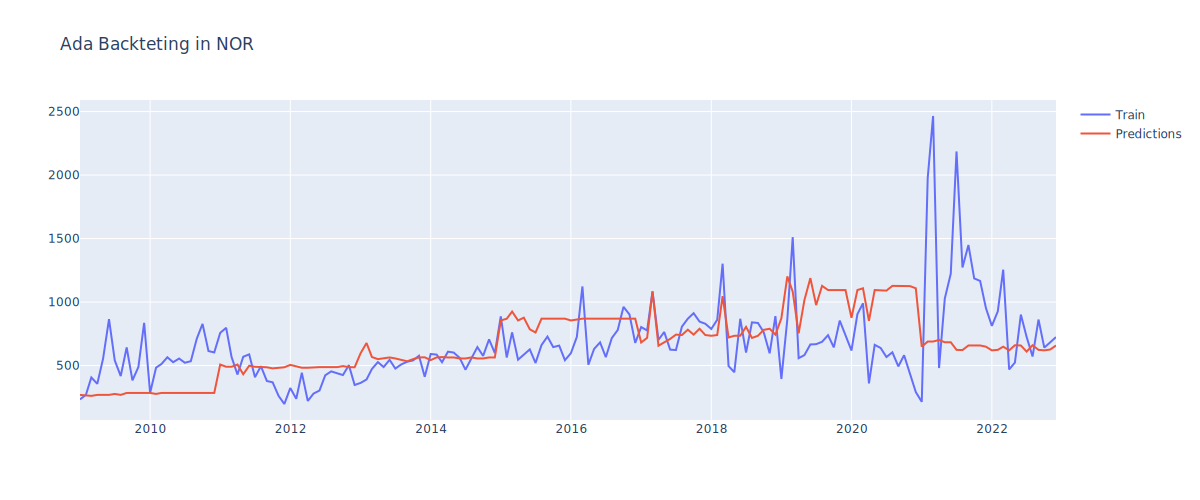

   feature  importance
0    lag_1    0.169943
11  lag_12    0.145766
3    lag_4    0.138808
1    lag_2    0.136935
2    lag_3    0.089591
9   lag_10    0.088055
5    lag_6    0.062586
13    LTIR    0.042966
15      UR    0.032268
7    lag_8    0.029693
10  lag_11    0.020481
4    lag_5    0.015232
14     TIV    0.013282
6    lag_7    0.006131
8    lag_9    0.005821
12     CPI    0.002442 

GB Backtesting:
Mean Absolute Error: 243.48.
Root Mean Squared Error: 332.03.
Mean Absolute Percentage Error: 43.86%.
Accuracy = 56.14%.


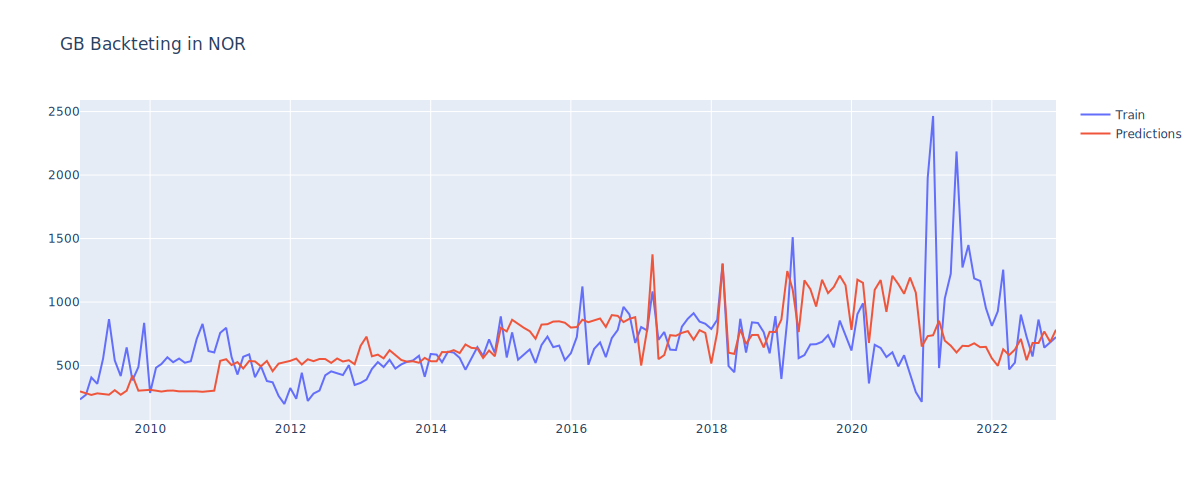

   feature  importance
1    lag_2    0.218981
0    lag_1    0.180547
11  lag_12    0.083824
3    lag_4    0.080444
2    lag_3    0.076840
7    lag_8    0.070928
13    LTIR    0.067171
14     TIV    0.060667
5    lag_6    0.033437
4    lag_5    0.028165
10  lag_11    0.027560
12     CPI    0.027078
9   lag_10    0.025669
15      UR    0.007767
8    lag_9    0.005590
6    lag_7    0.005332 

XGB Backtesting:
Mean Absolute Error: 224.23.
Root Mean Squared Error: 311.62.
Mean Absolute Percentage Error: 41.22%.
Accuracy = 58.78%.


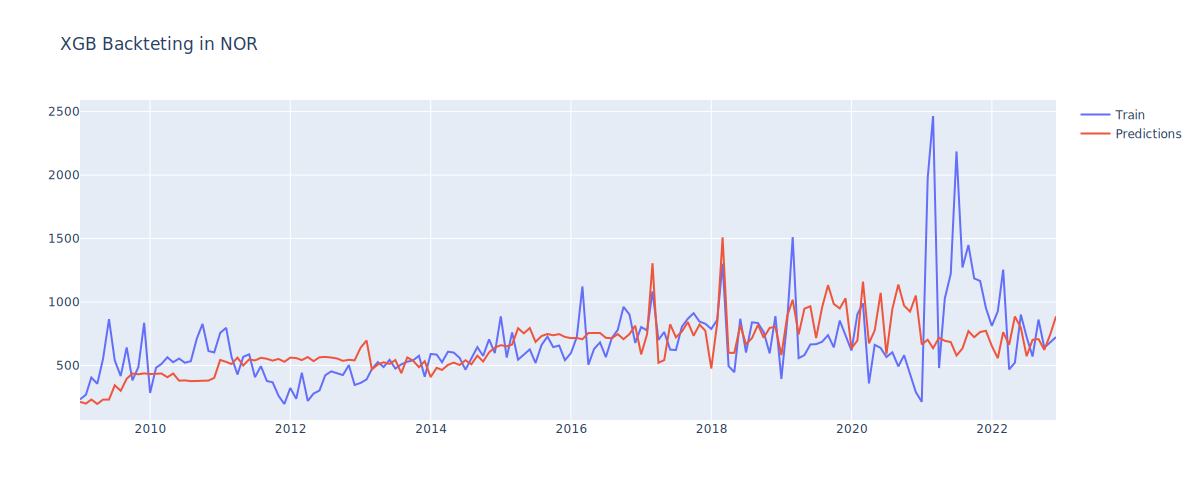

   feature  importance
13    LTIR    0.168635
11  lag_12    0.139256
7    lag_8    0.126675
12     CPI    0.107192
0    lag_1    0.077963
14     TIV    0.077031
5    lag_6    0.074626
1    lag_2    0.066266
2    lag_3    0.046553
9   lag_10    0.037945
4    lag_5    0.028261
8    lag_9    0.015714
6    lag_7    0.011809
3    lag_4    0.010346
10  lag_11    0.008512
15      UR    0.003216 

LGBM Backtesting:
Mean Absolute Error: 219.05.
Root Mean Squared Error: 325.14.
Mean Absolute Percentage Error: 43.37%.
Accuracy = 56.63%.


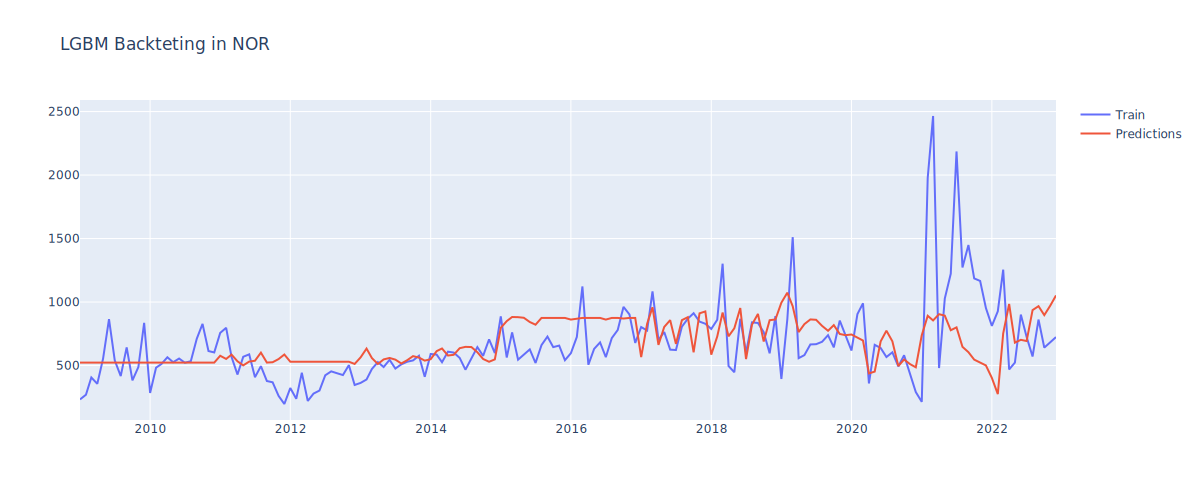

   feature  importance
11  lag_12          75
0    lag_1          72
2    lag_3          51
1    lag_2          48
9   lag_10          44
12     CPI          41
13    LTIR          41
7    lag_8          36
14     TIV          27
8    lag_9          25
3    lag_4          24
5    lag_6          23
10  lag_11          20
6    lag_7          19
15      UR          18
4    lag_5          16 

RF Backtesting:
Mean Absolute Error: 238.94.
Root Mean Squared Error: 332.70.
Mean Absolute Percentage Error: 45.21%.
Accuracy = 54.79%.


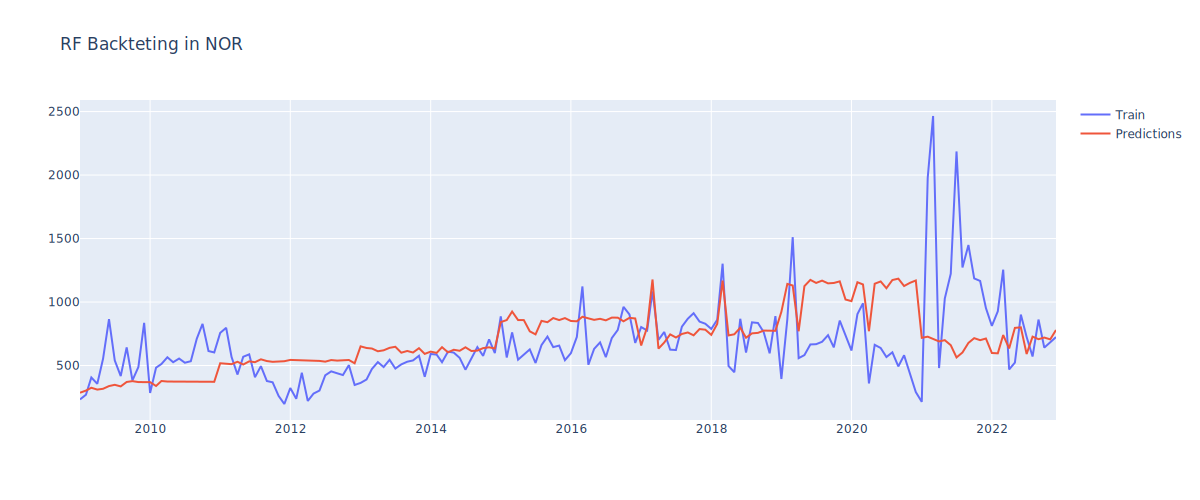

   feature  importance
0    lag_1    0.222225
1    lag_2    0.129084
2    lag_3    0.117114
11  lag_12    0.085285
3    lag_4    0.081806
14     TIV    0.066055
13    LTIR    0.055501
7    lag_8    0.039202
9   lag_10    0.038586
10  lag_11    0.032990
5    lag_6    0.030522
4    lag_5    0.029693
12     CPI    0.028882
8    lag_9    0.018619
6    lag_7    0.012596
15      UR    0.011841 

ET Backtesting:
Mean Absolute Error: 260.55.
Root Mean Squared Error: 356.07.
Mean Absolute Percentage Error: 48.88%.
Accuracy = 51.12%.


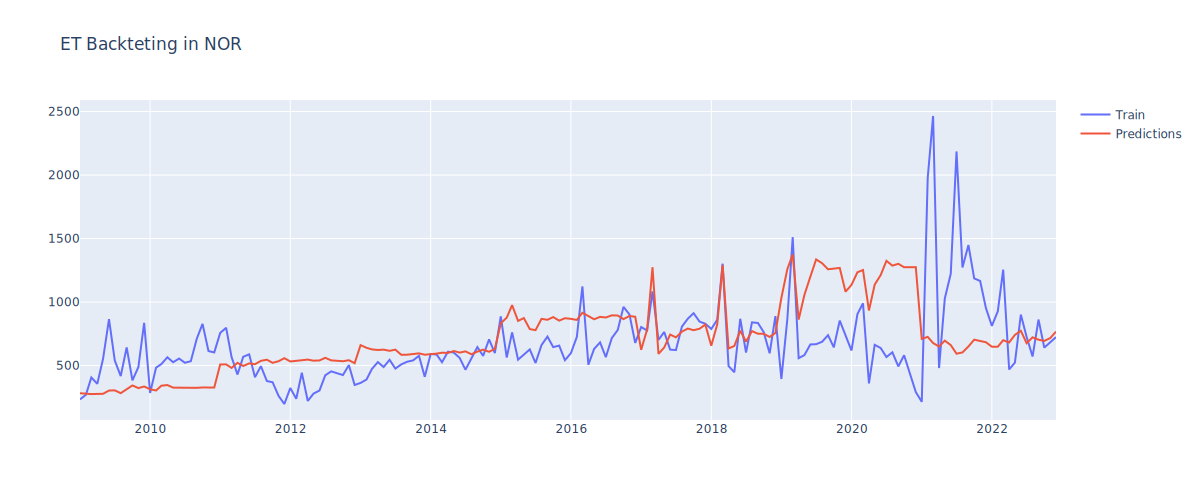

   feature  importance
0    lag_1    0.165887
3    lag_4    0.120676
13    LTIR    0.106044
1    lag_2    0.098613
11  lag_12    0.081609
2    lag_3    0.065412
14     TIV    0.059264
12     CPI    0.043228
9   lag_10    0.042618
4    lag_5    0.041594
10  lag_11    0.035378
5    lag_6    0.031980
7    lag_8    0.031962
6    lag_7    0.031423
8    lag_9    0.025261
15      UR    0.019051 



In [48]:
# Models
modelclasses = [
    ["Ada", AdaBoostRegressor],
    ["GB", GradientBoostingRegressor],    
    ["XGB", XGBRegressor],
    ["LGBM", LGBMRegressor],    
    ["RF", RandomForestRegressor],
    ["ET", ExtraTreesRegressor],
]

number_of_lags = 12   # Number of lags 

for model_name, Model in modelclasses:
    
    # Create forecaster
    forecaster = ForecasterAutoreg(
            regressor = Model(),
            lags = number_of_lags
    )
    
    # Fit model
    forecaster.fit(y=train[dep_var], exog=train_exo)    
        
    # Predict
    preds = forecaster.predict(steps=steps, exog=test_exo)
    
    # Backtest
    backtest(model_name, forecaster)

    # Feature importance
    feature_importance = forecaster.get_feature_importance().sort_values(by='importance', ascending=False)
    print(feature_importance, "\n")

In [49]:
def plot_metrics(m, w, h, error: bool):

    chart = m.transpose()
    if error:
        chart.drop(['Accuracy'], axis=1, inplace=True)
    else:
        chart.drop(['MAE', 'RMSE', 
                    'MAPE'], axis=1, inplace=True)
    ax = chart.plot.bar(title="Models Performance (" + country + ' /  ' 
            + dep_var + ')',
            figsize=(w, h))        
    for c in ax.containers:        
        ax.bar_label(c, fmt='%0.2f', label_type='edge', padding=5)
    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

### Summary

In [50]:
metrics

,Ada,GB,XGB,LGBM,RF,ET
MAE,251.470727,243.481216,224.226919,219.049898,238.936429,260.548393
RMSE,335.558201,332.034268,311.624839,325.143782,332.699192,356.067907
MAPE,46.228885,43.859704,41.219653,43.368018,45.207522,48.881409
Accuracy,53.771115,56.140296,58.780347,56.631982,54.792478,51.118591


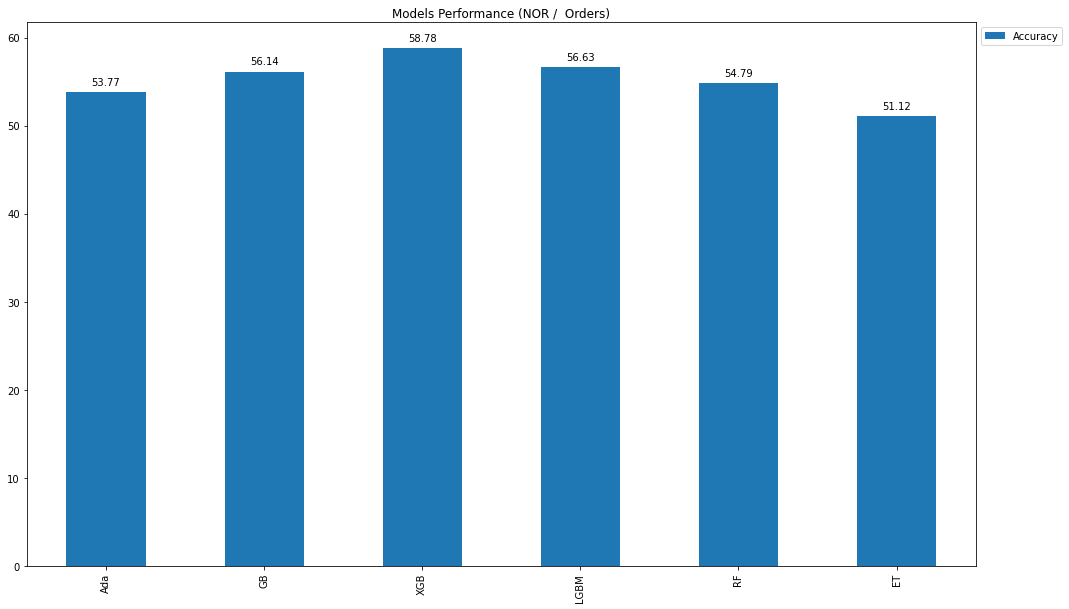

In [51]:
plot_metrics(metrics, 17, 10, False)

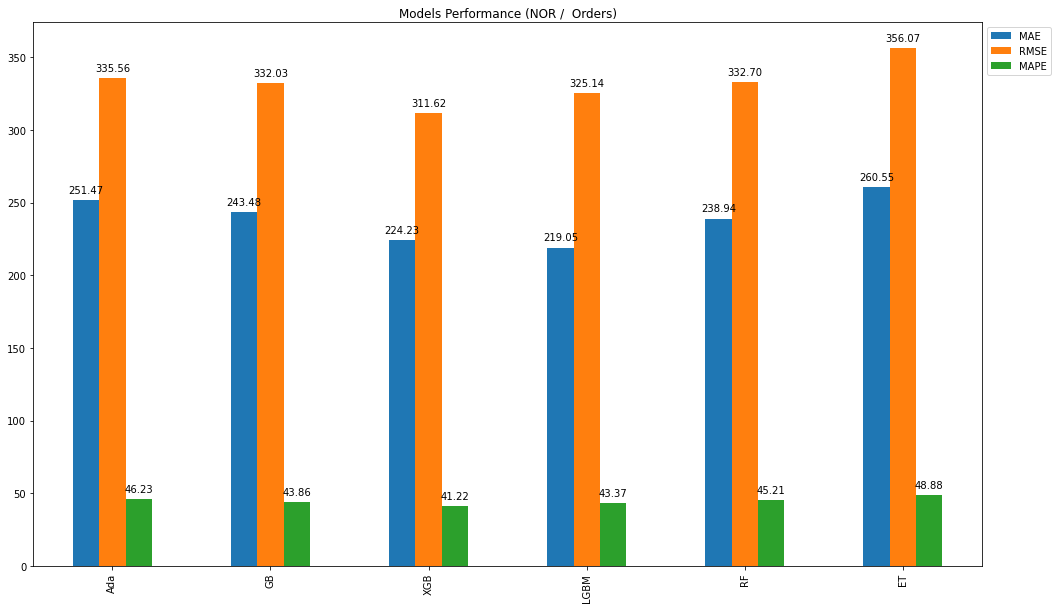

In [52]:
plot_metrics(metrics, 17, 10, True)